# Data loading

In [98]:
import pandas as pd

#Reads the data
data = pd.read_csv('./Demanda_2015.txt', sep=';', encoding='utf-8')

# Converts columns date and time to datetimes
data['date'] = pd.to_datetime(data['date'], format="%d/%m/%y")
data['time'] = pd.to_datetime(data['time'], format="%H:%M").dt.time
data['time'] = data['time'].apply(lambda x: x.strftime('%H:%M'))

In [99]:
data.head()

,date,time,consumption
0,2015-01-01,00:00,25459
1,2015-01-01,00:10,25591
2,2015-01-01,00:20,25531
3,2015-01-01,00:30,25453
4,2015-01-01,00:40,25329


# Data preprocessing

## Creating new info

In [100]:
data['day_of_week'] = data["date"].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
print(data.head())

        date   time  consumption  day_of_week  is_weekend
0 2015-01-01  00:00        25459            3           0
1 2015-01-01  00:10        25591            3           0
2 2015-01-01  00:20        25531            3           0
3 2015-01-01  00:30        25453            3           0
4 2015-01-01  00:40        25329            3           0


## Outliers

In [101]:
def calculate_outliers(data, data_to_return = "date"):

    Q1, Q3 = data['consumption'].quantile([0.25, 0.75]) # Calculates the first and third quartiles
    IQR = Q3 - Q1 # Calculates the Interquartile Range

    lower_limit = Q1 - 1.5 * IQR # Calculates the lower limit
    upper_limit = Q3 + 1.5 * IQR # Calculates the upper limit

    outliers = data[(data['consumption'] < lower_limit) | (data['consumption'] > upper_limit)]

    return outliers[data_to_return]


In [102]:
check_mean = data.groupby('date')['consumption'].mean().reset_index()
#prints daydata of 2015-04-03
print(check_mean[check_mean['date'] == '2015-04-03'])

         date   consumption
92 2015-04-03  21604.944444


In [103]:
day_data = data.groupby('date')['consumption'].mean().reset_index()
outliers = calculate_outliers(day_data)
outliers
#Stores the days with outliers (only the date, not the time) in a list in string format 
outliers_dates = [str(date.date()) for date in outliers]
print(outliers_dates)

['2015-04-03', '2015-04-05', '2015-12-25']


In [104]:
# Obtains the mean value for each hour of each day ofthe week 
mean_demand = data.groupby(['day_of_week', 'time'])['consumption'].mean().reset_index()

# Replaces the values of the outliers with the mean value of the same hour of the same day of the week
for date in outliers_dates:
    day_of_week = data[data['date'] == date].iloc[0]['day_of_week']
    for time in data[data['date'] == date]['time']:
        mean_value = mean_demand[(mean_demand['day_of_week'] == day_of_week) & (mean_demand['time'] == time)]['consumption'].values[0]
        data.loc[(data['date'] == date) & (data['time'] == time), 'consumption'] = int(mean_value)

In [105]:
check_mean = data.groupby('date')['consumption'].mean().reset_index()
#prints daydata of 2015-04-03
print(check_mean[check_mean['date'] == '2015-04-03'])

         date   consumption
92 2015-04-03  29221.493056


In [106]:
day_data_processed = data.groupby('date')['consumption'].mean().reset_index()
outliers_processed = calculate_outliers(day_data_processed, "consumption")
outliers_processed

Series([], Name: consumption, dtype: float64)

## Creating horizon

In [107]:
# Adding horizon information to each row
for lag in range(1, 25):  # 10 minutes lag till 4 hours (4h * 60 min/h / 10 min = 24)
    data[f'horizon_{lag}'] = data['consumption'].shift(lag)

# Removing the rows with NaN values
data = data.dropna()

In [108]:
data.head()

,date,time,consumption,day_of_week,is_weekend,horizon_1,horizon_2,horizon_3,horizon_4,horizon_5,...,horizon_15,horizon_16,horizon_17,horizon_18,horizon_19,horizon_20,horizon_21,horizon_22,horizon_23,horizon_24
24,2015-01-01,04:00,20725,3,0,20920.0,21059.0,21252.0,21477.0,21695.0,...,24391.0,24678.0,24853.0,25093.0,25247.0,25329.0,25453.0,25531.0,25591.0,25459.0
25,2015-01-01,04:10,20480,3,0,20725.0,20920.0,21059.0,21252.0,21477.0,...,24149.0,24391.0,24678.0,24853.0,25093.0,25247.0,25329.0,25453.0,25531.0,25591.0
26,2015-01-01,04:20,20369,3,0,20480.0,20725.0,20920.0,21059.0,21252.0,...,23905.0,24149.0,24391.0,24678.0,24853.0,25093.0,25247.0,25329.0,25453.0,25531.0
27,2015-01-01,04:30,20230,3,0,20369.0,20480.0,20725.0,20920.0,21059.0,...,23516.0,23905.0,24149.0,24391.0,24678.0,24853.0,25093.0,25247.0,25329.0,25453.0
28,2015-01-01,04:40,20084,3,0,20230.0,20369.0,20480.0,20725.0,20920.0,...,23293.0,23516.0,23905.0,24149.0,24391.0,24678.0,24853.0,25093.0,25247.0,25329.0


## Splitting data
We need to predict data from 8 of June to 14 of June. We are not going to use data after 14 June as training because it could give some information that we should not have.

In [109]:
# Dividing into train and test datasets (test dataset is from 8 of june to 14 of june) That means data before 2015-06-08 and after 2015-06-14 is training data
train_data = data[data['date'] < '2015-06-08']
test_data = data[data['date'] >= '2015-06-08']
test_data = test_data[test_data['date'] < '2015-06-15']

In [110]:
x_train = train_data.drop(columns=['consumption', 'date', 'time'])
y_train = train_data['consumption']

x_test = test_data.drop(columns=['consumption', 'date', 'time'])
# y test contains date, time and consumption
y_test = test_data[['date', 'time', 'consumption']]
dates_test = test_data['date']

## Data normalization
Method used for normalization is minimax

In [111]:
def encode(data, column, min, max):
    data_copy = data.copy()
    if column:
        data_copy[column] = (data[column] - min) / (max - min)
    else: #Data is a series
        data_copy = (data - min) / (max - min)
    return data_copy

def decode(data, column, min, max):
    data_copy = data.copy()
    if column:
        data_copy[column] = data[column] * (max - min) + min
    else:
        data_copy = data * (max - min) + min
    return data_copy

# Normalizing the data (except day_of_week and is_weekend)
min_value = x_train.min()
max_value = x_train.max()
min_consumption_value = y_train.min()
max_consumption_value = y_train.max()

#Removes day_of_week and is_weekend from the normalization
min_value = min_value.drop(['day_of_week', 'is_weekend'])
max_value = max_value.drop(['day_of_week', 'is_weekend'])

In [112]:
# Normalizate the data, and converts consumption into a float
for column in min_value.index:
    x_train = encode(x_train, column, min_value[column], max_value[column])
    x_test = encode(x_test, column, min_value[column], max_value[column])

y_train = encode(y_train, None, min_consumption_value, max_consumption_value)

# Model

## Training

In [113]:
import xgboost as xgb
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42
)

model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Evaluation

In [114]:
y_pred = model.predict(x_test)
y_pred = decode(y_pred, None, min_consumption_value, max_consumption_value)

In [116]:
MAE = (y_test["consumption"] - y_pred).abs().mean()
print(round(MAE, 2))

176.02


In [117]:
# Creates a Dataframe containing date, time and the predicted consumption
y_pred_df = pd.DataFrame(y_test)
y_pred_df['prediction'] = y_pred
print(y_pred_df.head())

            date   time  consumption    prediction
22752 2015-06-08  00:00        26076  25894.076880
22753 2015-06-08  00:10        25709  25522.465982
22754 2015-06-08  00:20        25413  25130.709222
22755 2015-06-08  00:30        25059  25029.914065
22756 2015-06-08  00:40        24844  24763.833026


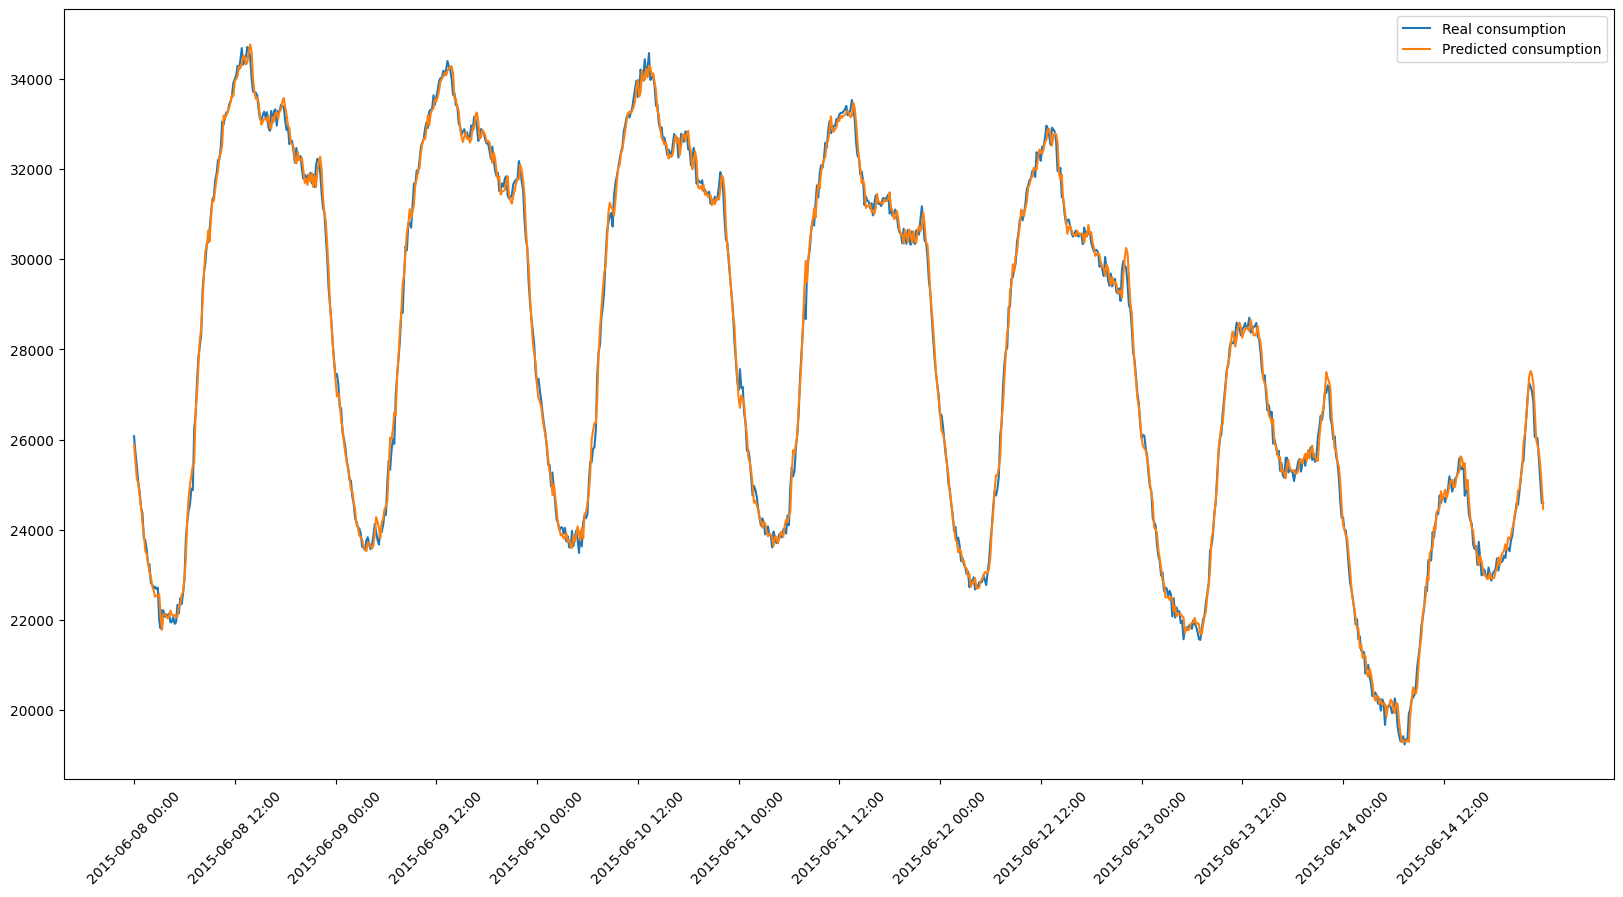

In [121]:
import matplotlib.pyplot as plt

# Creates the x labels and the hour labels have the format 'YYYY-MM-DD HH:MM'
x_labels = [f'{date.date()} {time}' for date, time in zip(y_pred_df['date'], y_pred_df['time'])]

# Plots the real consumption and the predicted consumption
plt.figure(figsize=(20, 10))
plt.plot(x_labels, y_pred_df['consumption'], label='Real consumption')
plt.plot(x_labels, y_pred_df['prediction'], label='Predicted consumption')
#Shows only 10 x labels
plt.xticks(x_labels[::int(len(x_labels)/14)], rotation=45)
plt.legend()
